# reproducing a figure from Avseth et al., 2001

Most of the data I am using for these [notes that I'm writing](https://github.com/aadm/geophysical_notes) come from a wonderful book written in 2005 by Per Avseth, Tapan Mukerji and Gary Mavko, "Quantitative Seismic Interpretation" (QSI).

This book strikes a perfect compromise between theory and practice, and it never gets old; I am still using it for inspiration, reference and as a practical guide for my daily job.

These last few weeks I have been working with AVO projections, doing everything from scratch in Python; I also wanted to share the way I did things so that meant reproducing all the work with openly accessible data. A few months ago I wrote [a little tutorial on seismic petrophysics](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb) using well data from the QSI website. Neat little 3D seismic cubes were also available in this dataset so I began using those my new notebook on AVO projections, until I found some discrepancies with the material that Avseth et al. have published.

There was one particular figure that bothered me, because I was not really able to understand if there was anything wrong with data loading or what else; it is found at page 259, figure 5.1; it is also present in [Avseth's PhD thesis](https://pangea.stanford.edu/researchgroups/srb/resources/theses) and in a paper published in 2001 by Avseth et al. on Geophysics: "Seismic reservoir mapping from 3-D AVO in a North Sea turbidite system". 

t is really a minor thing, one of the little distractions that nonetheless have a catastrophic effect on my productivity. But I got stuck so deeply into it that the only way for me to be at peace is to go public and show what I did to to reproduce the damn figure.

First, let's see the figure:

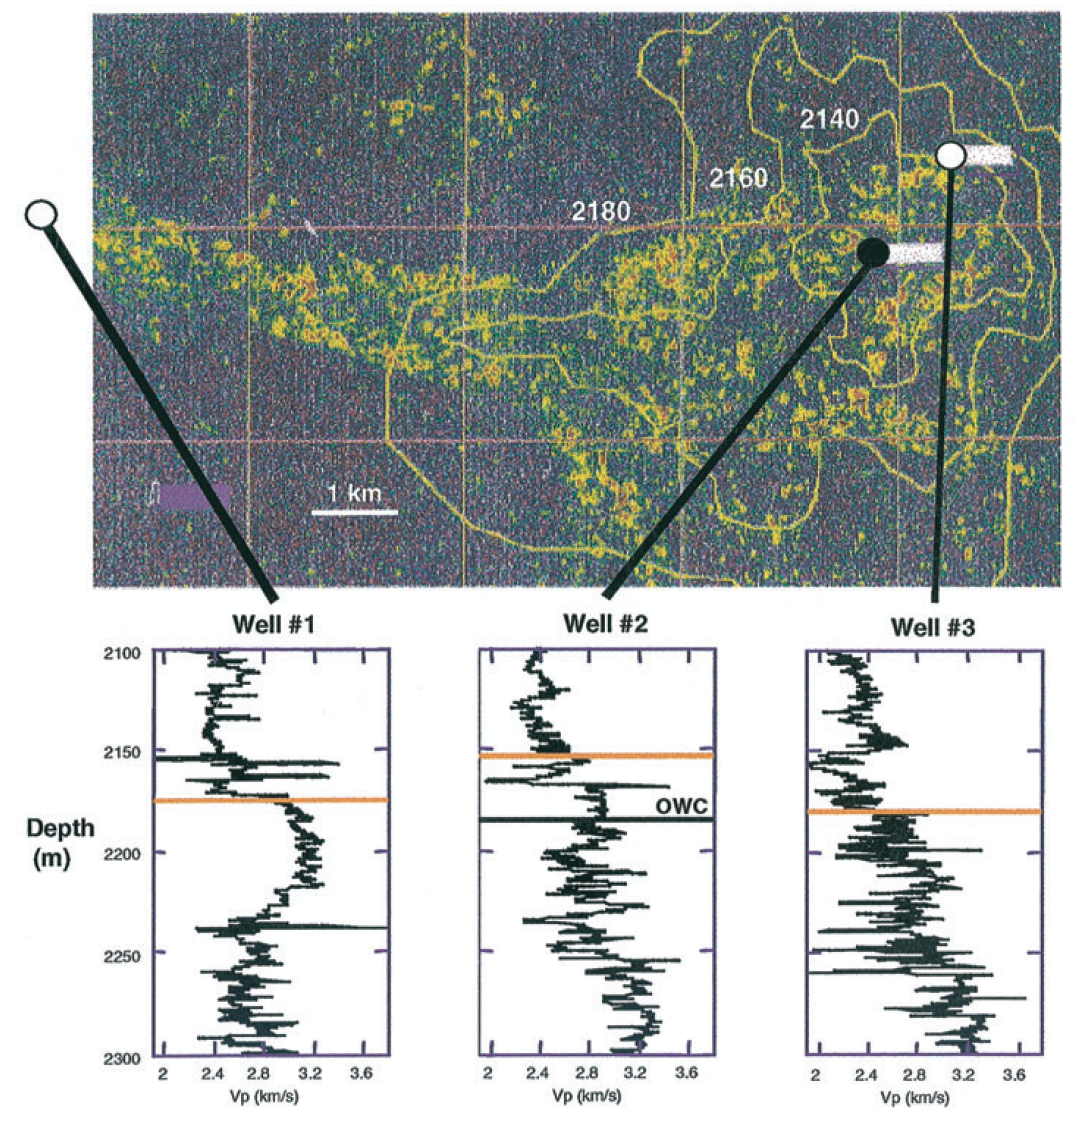

In [1]:
from IPython.display import Image
Image(filename='Avseth_2001_fig1.png', width=800)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import segypy
from scipy.interpolate import griddata
import scipy.ndimage as ndimage

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

In [6]:
w1=np.loadtxt('well_1.txt',skiprows=1)
w1z=w1[:,0]
w1vp=w1[:,2]

w2=np.recfromcsv('qsiwell2.csv',names=True)
w2z=w2['depth']
w2vp=w2['vp']/1e3

w3=np.recfromcsv('qsiwell3.csv',names=True)
w3z=w3['depth']
w3vp=w3['vp']/1e3

w5=np.recfromcsv('qsiwell5.csv',names=True)
w5z=w5['depth']
w5vp=304.800/w5['dt']


well1_il, well1_xl = 1448, 945
well2_il, well2_xl = 1376, 1776
well3_il, well3_xl =1468, 1847

tops_w1={'Heimdal': 2170}
tops_w2={'Heimdal': 2153,'OWC': 2183}
tops_w3={'Heimdal': 2180}

In [10]:
inl=np.arange(1300,1502,2)
crl=np.arange(1500,2002,2)
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])

filename='3d_nearstack.sgy'
f=open(filename, 'rb')
seis,header,trace_headers=segypy.read_segy(f)
near=seis.reshape(header['ns'],inl.size,crl.size)

lagtime=trace_headers['LagTimeA'][0]*-1
twt=np.arange(lagtime,header['dt']/1e3*header['ns']+lagtime,header['dt']/1e3)

In [12]:
amp=np.zeros(hrz.size)
for i in range(hrz.size):
    ii_idx = inl.tolist().index(hrz['il'][i])
    cc_idx = crl.tolist().index(hrz['xl'][i])
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()
    amp[i] = near[zz_idx, ii_idx, cc_idx].flatten()

In [16]:
xi = np.linspace(inl.min(), inl.max(),500)
yi = np.linspace(crl.min(), crl.max(),500)
X, Y = np.meshgrid(xi, yi)
Z=griddata((hrz['il'],hrz['xl']),hrz['z'],(X,Y),method='cubic')
Zf=ndimage.gaussian_filter(Z,sigma=8,order=0)

A=griddata((hrz['il'],hrz['xl']),amp,(X,Y),method='cubic')

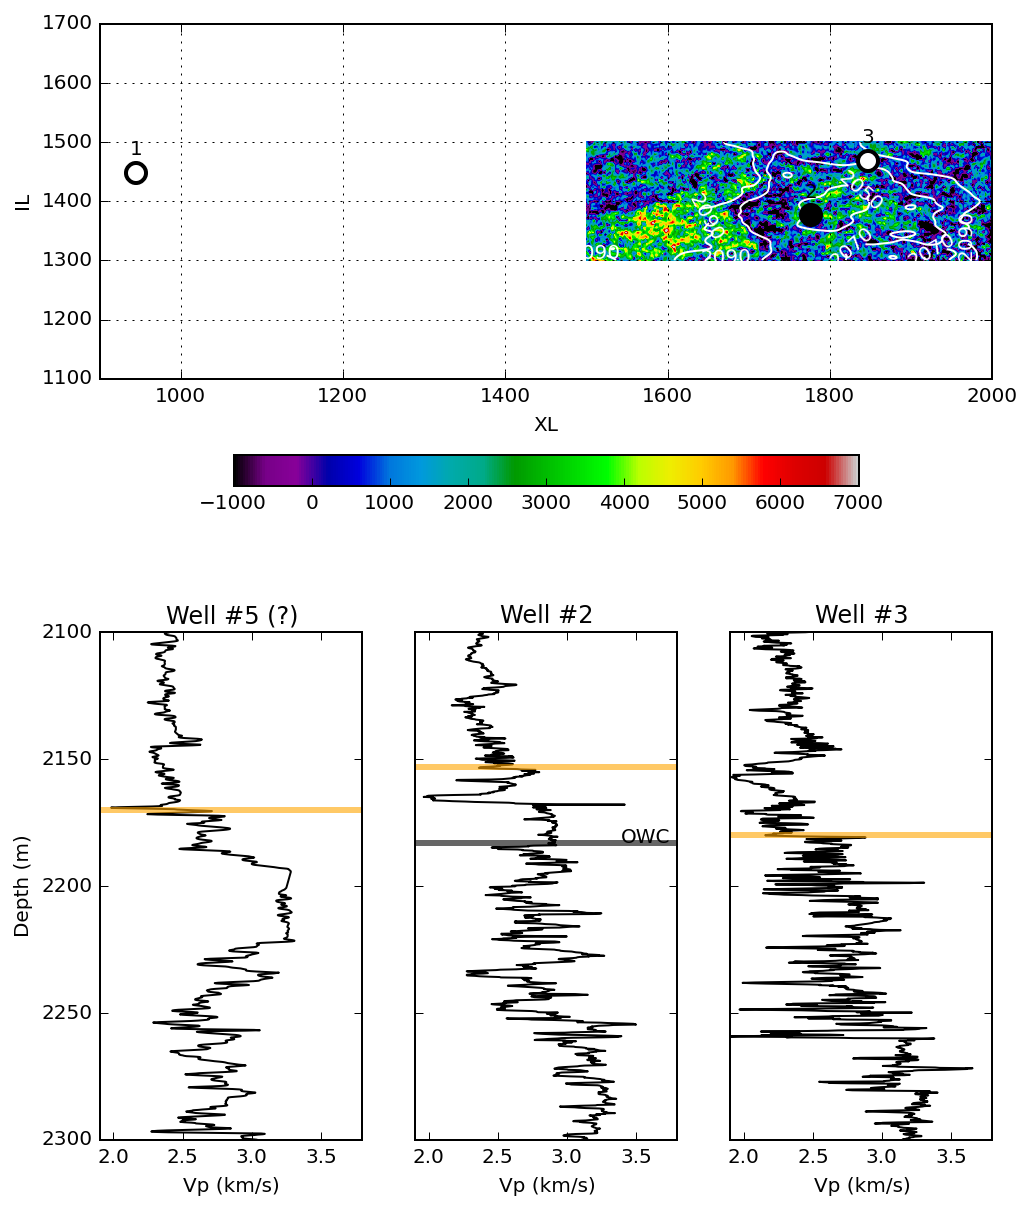

In [21]:
f,ax=plt.subplots(figsize=(8, 10),facecolor='w')
ax0 = plt.subplot2grid((2,3), (0, 0), colspan=3)
# im0=ax0.pcolormesh(Y,X,Z,cmap='gist_earth_r')
im0=ax0.pcolormesh(Y, X, A, cmap='nipy_spectral', vmin=-1000,vmax=7000)
CS=ax0.contour(Y,X,Zf,levels=[2050,2070,2090],colors='w')
ax0.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
plt.colorbar(im0, ax=ax0, orientation='horizontal', shrink=0.7)
ax0.plot(well1_xl,well1_il,'ow',ms=10,mew=2)
ax0.text(well1_xl,well1_il+30,'1',ha='center')
ax0.plot(well2_xl,well2_il,'ok',ms=10,mew=2)
ax0.text(well2_xl,well2_il+30,'2',ha='center')
ax0.plot(well3_xl,well3_il,'ow',ms=10,mew=2)
ax0.text(well3_xl,well3_il+30,'3',ha='center')
ax0.set_xlabel('XL'), ax0.set_ylabel('IL')
ax0.set_xlim(900,2000), ax0.set_ylim(1100,1700)
ax0.grid()
ax1 = plt.subplot2grid((2,3), (1, 0))
ax1.plot(w5vp,w5z,'-k')
ax1.set_title('Well #5 (?)')
ax1.set_ylabel('Depth (m)')
ax1.axhline(y=float(tops_w1['Heimdal']),color='orange',lw=3,alpha=0.6)
ax2 = plt.subplot2grid((2,3), (1, 1))
ax2.plot(w2vp,w2z,'-k')
ax2.set_title('Well #2')
ax2.axhline(y=float(tops_w2['Heimdal']),color='orange',lw=3,alpha=0.6)
ax2.axhline(y=float(tops_w2['OWC']),color='black',lw=3,alpha=0.6)
ax2.text(3.4,tops_w2['OWC'],'OWC')
ax3 = plt.subplot2grid((2,3), (1, 2))
ax3.plot(w3vp,w3z,'-k')
ax3.set_title('Well #3')
ax3.axhline(y=float(tops_w3['Heimdal']),color='orange',lw=3,alpha=0.6)
f.subplots_adjust(wspace=.2)
for aa in [ax1, ax2,ax3]:
    aa.set_xlabel('Vp (km/s)')
    aa.set_ylim(2300,2100)
    aa.set_xlim(1.9,3.8)
    if aa != ax1:
        aa.set_yticklabels([])

